# Mounting drive and unzipping Dataset

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile
with zipfile.ZipFile('drive/My Drive/data_classifier_augmented.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
!pip install scipy==1.1.0


     |████████████████████████████████| 31.2MB 1.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1


# Preprocessing part 2

In [0]:
import pandas as pd
import seaborn as sns
import numpy as np
import keras
import math
from scipy.misc import imread,imresize
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,Input
from keras.layers import Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras.initializers import TruncatedNormal, Constant

In [0]:
def plot_classes(df):
  forward_class= df.forward[df['forward']==1].count()
  right_class=df.right[df['right']==1].count()
  left_class=df.left[df['left']==1].count()
  not_valid=df.left[(df['left']==0) & (df['right']==0) & (df['forward']==0)].count()
  classes=[ 'forward', 'right', 'left', 'non-valid']
  percentages= [forward_class, right_class, left_class, not_valid]
  sns.barplot(x=classes, y=percentages)

In [7]:
data= pd.read_csv("labels_augmented.csv")
data.drop(["Unnamed: 0"], axis=1,inplace=True)

data.head(10)

,img,forward,right,left
0,17546.jpg,0,1,0
1,48191.jpg,1,0,0
2,2977.jpg,0,1,0
3,51541.jpg,0,0,1
4,13236.jpg,1,0,0
5,39230.jpg,0,0,1
6,57295.jpg,0,0,1
7,31387.jpg,0,1,0
8,25567.jpg,1,0,0
9,127.jpg,0,1,0


## Downsampling

In [0]:
def downsample (df):
  '''
  Takes a dataset in a dataframe and downsample the data till each class 
  has the same number of examples as others. Returns the downsampled dataframe.
  Note: The function is not generic and is meant to serve the structure of my own dataset.
  '''
  forward_class= df.forward[data['forward']==1].count()
  right_class=df.right[data['right']==1].count()
  left_class=df.left[data['left']==1].count()
  
  class_size= min(forward_class, right_class, left_class)
  forward = data[data['forward']==1].sample(n=class_size,random_state=42)
  left= data[data['left']==1].sample(n=class_size, random_state=42)
  right= data[data["right"]==1].sample(n=class_size, random_state=42)
  
  downsampled= pd.concat([forward, left, right]).sample(frac=1).reset_index(drop=True)
  
  return downsampled


  

In [0]:
data_downsampled= downsample(data)

In [10]:
data_downsampled.head(10)

,img,forward,right,left
0,44414.jpg,1,0,0
1,56762.jpg,1,0,0
2,58964.jpg,0,1,0
3,42758.jpg,0,1,0
4,23.jpg,0,0,1
5,18983.jpg,0,0,1
6,20458.jpg,1,0,0
7,30657.jpg,0,0,1
8,10410.jpg,0,0,1
9,1242.jpg,0,0,1


In [11]:
print(data_downsampled.index.max())

54683


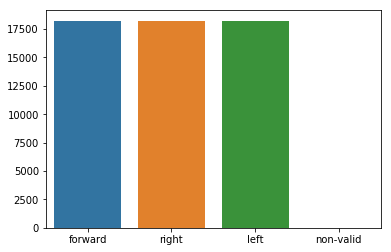

In [12]:
plot_classes(data_downsampled)

**Note**: Image resizing and normalization will be done during loading data in patches, thus they are not included in the preprocessing section.

## Splitting into Train, validation and test

In [0]:
train=data_downsampled[:int(data_downsampled.index.max()*0.75)]
validation= data_downsampled[int(data_downsampled.index.max()*0.75):int(data_downsampled.index.max()*0.8)].reset_index(drop=True)
test= data_downsampled[int(data_downsampled.index.max()*0.8):].reset_index(drop=True)


In [43]:
print(train.index.max())
print(validation.index.max())
print(test.index.max())

41011
2733
10937


In [15]:
test.head()

,img,forward,right,left
0,27520.jpg,0,1,0
1,176.jpg,1,0,0
2,35149.jpg,1,0,0
3,62685.jpg,0,1,0
4,10596.jpg,0,1,0


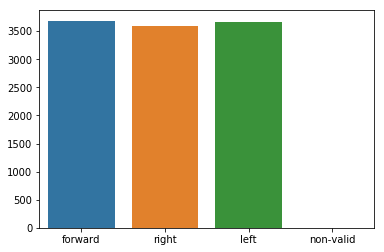

In [16]:
plot_classes(test)

* After splitting, the test set is almost balanced and doesn't need any further sampling.

# Benchmarking

* For benchmarking, a simple assumption is proposed that all examples are classified as Forward class.
* Using accuracy metric, let's evaluate this naive model.

In [17]:
forward_class= test.forward[test['forward']==1].count()
total= test.index.max()+1
benchmark_acc= forward_class/total
print("The Naive model benchmark gives accuracy of {}%".format(benchmark_acc*100))

The Naive model benchmark gives accuracy of 33.689888462241726%


# Training a CNN model from scratch

## Model Architecture

In [0]:
def getmodel():
    model=Sequential()
    model.add(Conv2D(12,(5,5),strides=(2,2),kernel_initializer=TruncatedNormal(stddev=0.1),bias_initializer=Constant(value=0.1),activation='elu',input_shape=(66,200,3),use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16,(3,3),strides=(2,2),kernel_initializer=TruncatedNormal(stddev=0.1),bias_initializer=Constant(value=0.1),activation='elu',use_bias=True))
    model.add(Conv2D(24,(5,5),strides=(2,2),kernel_initializer=TruncatedNormal(stddev=0.1),bias_initializer=Constant(value=0.1),activation='elu',use_bias=True))
    model.add(Flatten())
    model.add(Dense(units=1000,kernel_initializer=TruncatedNormal(stddev=0.1),bias_initializer=Constant(value=0.1),activation='elu',input_dim=960))
    model.add(Dropout(0.2))
    model.add(Dense(units=100,kernel_initializer=TruncatedNormal(stddev=0.1),bias_initializer=Constant(value=0.1),activation='elu',input_dim=1024))
    model.add(Dropout(0.2))
    model.add(Dense(units=10,kernel_initializer=TruncatedNormal(stddev=0.1),bias_initializer=Constant(value=0.1),activation='elu',input_dim=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=3,kernel_initializer=TruncatedNormal(stddev=0.1),bias_initializer=Constant(value=0.1),activation='softmax',input_dim=10))
    
  
    
    return model
model=getmodel()


In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 31, 98, 12)        912       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 49, 12)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 24, 16)         1744      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 10, 24)         9624      
_________________________________________________________________
flatten_3 (Flatten)          (None, 480)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              481000    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1000)             

## Training

In [0]:
batch_pointer= 0
base_path='data_classifier_augmented'
def generate_batch(df, batch_size=512):
    global batch_pointer
    train_data=df.index.max()+1
    y=np.array(df.drop(['img'],inplace=False,axis=1))
   
    while True:
        batch_start=batch_pointer%train_data
        batch_end=(batch_pointer+batch_size)%train_data
        if batch_end < batch_start:
          batch_end= train.index.max()
        
        X_batch=df.img[batch_start:batch_end]
        y_batch = y[batch_start:batch_end]
        images = np.array([np.int32(imresize(imread('/'.join([base_path, im]))[-150:], size=(66, 200))) /255 for im in X_batch])

        
        batch_pointer+=batch_size
        if batch_end==train.index.max():
          batch_pointer=0
        batch_pointer%=train_data
        
        yield images,y_batch

In [0]:
val_imgs=np.array([np.int32(
    imresize(imread('/'.join([base_path, im]))[-150:], size=(
        66, 200))) /255 for im in validation.img])
y_val= np.array(validation.drop(['img'],inplace=False, axis=1))

In [21]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
steps= math.ceil((train.index.max()+1)/128)
model.fit_generator(generate_batch(train,128),steps_per_epoch=steps ,
                    epochs=30,verbose=1, validation_data=(val_imgs,y_val))


Epoch 1/30
321/321 [==============================] - 128s 399ms/step - loss: 0.7096 - acc: 0.6770 - val_loss: 0.6102 - val_acc: 0.7249
Epoch 2/30
321/321 [==============================] - 127s 395ms/step - loss: 0.6136 - acc: 0.7263 - val_loss: 0.5531 - val_acc: 0.7542
Epoch 3/30
321/321 [==============================] - 127s 395ms/step - loss: 0.5712 - acc: 0.7475 - val_loss: 0.5267 - val_acc: 0.7590
Epoch 4/30
321/321 [==============================] - 127s 394ms/step - loss: 0.5424 - acc: 0.7609 - val_loss: 0.4939 - val_acc: 0.7791
Epoch 5/30
321/321 [==============================] - 127s 395ms/step - loss: 0.5155 - acc: 0.7716 - val_loss: 0.4802 - val_acc: 0.7890
Epoch 6/30
321/321 [==============================] - 127s 395ms/step - loss: 0.4928 - acc: 0.7815 - val_loss: 0.4644 - val_acc: 0.7893
Epoch 7/30
321/321 [==============================] - 127s 395ms/step - loss: 0.4694 - acc: 0.7923 - val_loss: 0.4564 - val_acc: 0.7955
Epoch 8/30
321/321 [============================

In [0]:
test_imgs=np.array([np.int32(
    imresize(imread('/'.join([base_path, im]))[-150:], size=(
        66, 200))) /255 for im in test.img])


In [55]:
y_test= np.array(test.drop(['img'],inplace=False, axis=1))
loss, acc=model.evaluate(test_imgs, y_test, batch_size=50)
print ('test_loss=%f'%loss)
print ('test_acc=%0.3f'%(acc*100)+'%')

10938/10938 [==============================] - 3s 244us/step
test_loss=0.367970
test_acc=88.801%
